In [1]:
import os
os.environ["UW_TIMING_ENABLE"] = "1"
import petsc4py
from petsc4py import PETSc


import underworld3 as uw
from underworld3.systems import Stokes
from underworld3 import function

import numpy as np
import sympy

import h5py
#import zarr # better to use h5py than zarray

In [2]:
x_min = -1.
x_max = 1.
z_min = 0
z_max = 1
res = 80

is_train = False

if is_train:
    indir = "/Users/jcgraciosa/Documents/codes/geo-neural-op/stokes-train-xdmf"
    indir = "/Users/jgra0019/Documents/codes/geo-neural-op/stokes-trial-data/stokes-train-xdmf"
    outdir = "/Users/jgra0019/Documents/codes/geo-neural-op/stokes-trial-data/stokes-train-h5"
    outfname = "/stokes_res80_steps90_train.h5"
else:
    indir = "/Users/jcgraciosa/Documents/codes/geo-neural-op/stokes-test-xdmf"
    indir = "/Users/jgra0019/Documents/codes/geo-neural-op/stokes-trial-data/stokes-test-xdmf"
    outdir = "/Users/jgra0019/Documents/codes/geo-neural-op/stokes-trial-data/stokes-test-h5"
    outfname = "/stokes_res80_steps01_test.h5"

fname = "stokes"

nsteps = 2

In [3]:
mesh = uw.meshing.UnstructuredSimplexBox(
    minCoords=(x_min, z_min), maxCoords=(x_max, z_max), cellSize=1.0 / res, regular=False
)

In [4]:
# %% [markdown]
# ####  Create Stokes object and the required mesh variables (velocity and pressure)

# %%
v = uw.discretisation.MeshVariable("U", mesh, mesh.dim, degree=2)
p = uw.discretisation.MeshVariable("P", mesh, 1, degree=1)
bfz = uw.discretisation.MeshVariable("BF", mesh, 1, degree=2) # for the body force
visc = uw.discretisation.MeshVariable("VISC", mesh, 1, degree=2)

In [5]:
# positions to interpolate
x_grid = np.linspace(x_min, x_max, res)
z_grid = np.linspace(z_min, z_max, res)

xx, zz = np.meshgrid(x_grid, z_grid)

pos_eval = np.zeros((xx.flatten().shape[0], 2))
pos_eval[:, 0] = xx.flatten()
pos_eval[:, 1] = zz.flatten()

# zarrays that will contain the data
vxvzp = np.zeros([nsteps, 3, xx.shape[0], xx.shape[1]])
bfv = np.zeros([nsteps, 2, xx.shape[0], xx.shape[1]]) # body force and viscosity


In [6]:
# loop through all the saved mesh variables
step = 0

while step < nsteps:

    print("step: ", step)
    infile = indir + "/" + fname

    print("Reading mesh variables...")
    print(infile + ".U." + str(step) + ".h5")
    v.read_from_vertex_checkpoint(infile + ".U." + str(step) + ".h5", data_name="U")
    p.read_from_vertex_checkpoint(infile + ".P." + str(step) + ".h5", data_name="P")
    bfz.read_from_vertex_checkpoint(infile + ".BF." + str(step) + ".h5", data_name="BF")
    visc.read_from_vertex_checkpoint(infile + ".VISC." + str(step) + ".h5", data_name="VISC")

    # calculate the body force, ux, uz, pressure
    print("Calculating fields ...")
    bf_z = uw.function.evaluate(bfz.sym[0], pos_eval)
    ux_proj = uw.function.evaluate(v.sym[0], pos_eval)
    uz_proj = uw.function.evaluate(v.sym[1], pos_eval)
    p_proj = uw.function.evaluate(p.sym[0], pos_eval)
    visc_proj = uw.function.evaluate(visc.sym[0], pos_eval)

    bf_z_rev = bf_z.reshape(xx.shape) # revert to rectangular mesh shape
    ux_rev = ux_proj.reshape(xx.shape)
    uz_rev = uz_proj.reshape(xx.shape)
    p_rev = p_proj.reshape(xx.shape)
    visc_rev = visc_proj.reshape(xx.shape)

    # pack the predictables one array - L, R, C
    print("Packing ...")
    vxvzp[step, 0, :, :] = ux_rev
    vxvzp[step, 1, :, :] = uz_rev
    vxvzp[step, 2, :, :] = p_rev

    # pack the inputs one array - L, R, C
    bfv[step, 0, :, :] = bf_z_rev
    bfv[step, 1, :, :] = visc_rev

    # # save the inputs and outputs
    # zarr.save(outputPath + "/vxvzp_{}.zarr".format(step), vxvzp)
    # zarr.save(outputPath + "/bfv_{}.zarr".format(step), bfv)

    step += 1

step:  0
Reading mesh variables...
/Users/jgra0019/Documents/codes/geo-neural-op/stokes-trial-data/stokes-test-xdmf/stokes.U.0.h5
Calculating fields ...
Packing ...
step:  1
Reading mesh variables...
/Users/jgra0019/Documents/codes/geo-neural-op/stokes-trial-data/stokes-test-xdmf/stokes.U.1.h5
Calculating fields ...
Packing ...


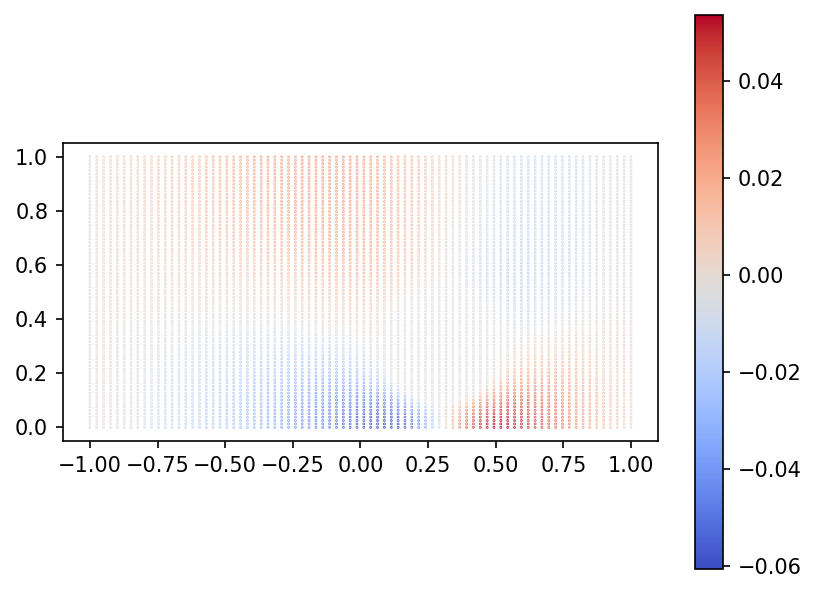

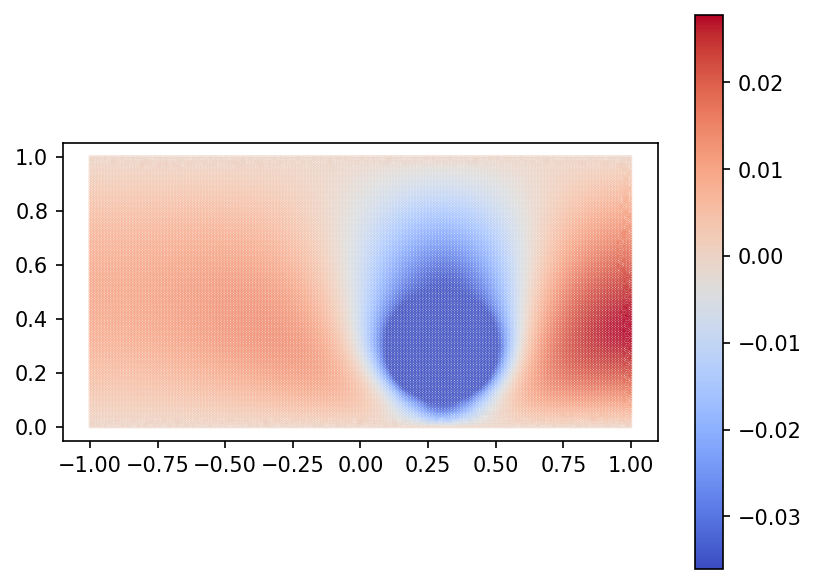

In [7]:
import matplotlib.pyplot as plt

int_var = ux_proj
mesh_var = v

fig, ax = plt.subplots(dpi = 150)
#out = ax.scatter(xx.flatten(), zz.flatten(), c = bf_z.flatten(), cmap = "coolwarm", s = 5)
out = ax.scatter(pos_eval[:, 0], pos_eval[:, 1], c = int_var, cmap = "coolwarm", s = 0.1)
plt.colorbar(out)
ax.set_aspect("equal")

with mesh.access():
    fig, ax = plt.subplots(dpi = 150)
    out = ax.scatter(mesh_var.coords[:, 0], mesh_var.coords[:, 1], c = mesh_var.data[:, 1], cmap = "coolwarm", s = 0.05)
    plt.colorbar(out)
    ax.set_aspect("equal")

In [8]:
# compare closeness of the data

i1 = 0
i2 = 0

print(np.allclose(vxvzp[i1, 0, :, :], vxvzp[i2, 0, :, :]))
print(np.allclose(vxvzp[i1, 1, :, :], vxvzp[i2, 1, :, :]))
print(np.allclose(vxvzp[i1, 2, :, :], vxvzp[i2, 2, :, :]))

print(np.allclose(bfv[i1, 0, :, :], bfv[i2, 0, :, :]))
print(np.allclose(bfv[i1, 1, :, :], bfv[i2, 1, :, :]))

True
True
True
True
True


In [9]:
# zarr.save(outdir + "/vxvzp_{}.zarr".format(step), vxvzp)
# zarr.save(outdir + "/bfv_{}.zarr".format(step), bfv)

# zarr.save(outdir + "/vxvzp.zarr", vxvzp)
# zarr.save(outdir + "/bfv.zarr", bfv)

# create h5 dataset here
hf = h5py.File(outdir + "/" + outfname, "w")
hf.create_dataset("x", data = bfv, dtype = "f")
hf.create_dataset("y", data = vxvzp, dtype = "f")
hf.close()

In [10]:
# # try to read

# hf_rd = h5py.file

In [11]:
# hf_rd_data["x"][0, :, :, :].shape

In [12]:
# # try to read
# rd_vxvzp = zarr.load(outdir + "/vxvzp.zarr")
# rd_bf_z_rev = zarr.load(outdir + "/bfz.zarr")

In [13]:
# rd_vxvzp.shape